In [49]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point
from shapely.ops import transform
import math
import rioxarray
import rasterio
import pyproj
import matplotlib.pyplot as plt
from rasterio.plot import show


In [2]:
# Load proximity data
coast_prox = rasterio.open("data/qgis/proximity-coast-line.tif")
powerline_prox = rasterio.open("data/qgis/proximity-power-line.tif")

In [3]:
# Load projected wind prediction
# Currently just using wind atlas data
cap_factor = rasterio.open("data/predictions/wind_projected.tif")

In [4]:
# Load water temp predictions and stations data
water_temp_stations = gpd.read_file('data/fmi/water_temp_stations.geojson')
# Project for distance calc
water_temp_stations_proj = water_temp_stations.to_crs("EPSG:3067")
water_temp_pred = pd.read_csv('data/predictions/water_preds.csv').rename(
    columns={"Station": "name", "Prediction": "water_temp"})
water_temp_stations = water_temp_stations.merge(water_temp_pred, on="name")
water_temp_stations

,name,geometry,water_temp
0,Kemi Ajos,POINT (24.51526 65.67337),6.629967
1,Raahe Lapaluoto,POINT (24.40708 64.66630),6.967584
2,Porvoo Emäsalo Vaarlahti,POINT (25.62509 60.20579),7.612832
3,Helsinki Kaivopuisto,POINT (24.95622 60.15363),7.761681
4,Vaasa Vaskiluoto,POINT (21.57118 63.08150),7.319557
5,Rauma Petäjäs,POINT (21.44263 61.13390),6.030093
6,Turku Ruissalo Saaronniemi,POINT (22.10053 60.42828),8.147957
7,Oulu Toppila,POINT (25.41820 65.04030),5.240790
8,Pietarsaari Leppäluoto,POINT (22.68958 63.70857),7.270417
9,Kaskinen Ådskär,POINT (21.21483 62.34395),3.203901


In [5]:
# Load weather predictions and stations
weather_stations = gpd.read_file('data/fmi/weather_stations.geojson')
weather_stations_proj = weather_stations.to_crs("EPSG:3067")
air_temp_pred = pd.read_csv('data/predictions/air_preds.csv').rename(
    columns={"Station": "name", "Prediction": "air_temp"})
wind_pred = pd.read_csv('data/predictions/wind_preds.csv').rename(
    columns={"Station": "name", "Prediction": "wind_speed"})
weather = (
    weather_stations
    .merge(wind_pred, on="name", how='left')
    .merge(air_temp_pred, on="name", how='left'))
display(weather)
display(weather[weather['geometry'].isna()])
weather = weather.dropna()
weather_stations_proj = weather_stations_proj[weather_stations_proj.index.isin(weather.index)]

,name,geometry,wind_speed,air_temp
0,Porvoo Kilpilahti satama,POINT (25.54916 60.30373),3.660095,4.906549
1,Parainen Utö,POINT (21.37479 59.77909),7.181010,6.504869
2,Lemland Nyhamn,POINT (19.95374 59.95911),7.472854,6.756552
3,Jomala Jomalaby,POINT (19.98686 60.17824),3.090676,5.091734
4,Hammarland Märket,POINT (19.13142 60.30098),7.645186,6.556185
...,...,...,...,...
215,Inari Ivalo lentoasema,POINT (27.41890 68.61336),2.708405,-1.112987
216,Ilmajoki Seinäjoki lentoasema,POINT (22.84272 62.68571),1.790030,2.662815
217,Rovaniemi lentoasema AWOS,POINT (25.84865 66.57283),3.697110,-0.019403
218,Jyväskylä lentoasema AWOS,POINT (25.68862 62.39332),2.239785,1.910450


,name,geometry,wind_speed,air_temp


In [6]:
# Min & max for normalization
min_water_temp = water_temp_stations['water_temp'].min()
max_water_temp = water_temp_stations['water_temp'].max()
water_spread = max_water_temp - min_water_temp
min_air_temp = weather['air_temp'].min()
max_air_temp = weather['air_temp'].max()

In [7]:
# Projection for points: distance calc
projection = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3067", always_xy=True).transform

In [125]:
# Input: any arbitrary point

def score(long, lat, verbose=False):
    eps = 0.00001
    point = Point(long, lat)
    proj = transform(projection, point)

    # Factor 1: sea water cooling
    coast_dist = next(coast_prox.sample([(long, lat)]))[0]
    closest_water = water_temp_stations.iloc[water_temp_stations_proj.distance(proj).idxmin()]
    # water prox score: sqrt(normalized_temp * (1/log(distance)))
    score_water_temp = (max_water_temp - closest_water['water_temp'])/ water_spread # 0-1
    score_water_prox = math.sqrt(score_water_temp * (1/max(1, math.log10(coast_dist + eps))))
    if verbose: print(
        f"{long=:.2f} {lat=:.2f} {coast_dist=:.2f} water_temp={closest_water['water_temp']:.2f} "
        f"{score_water_temp=:.2f} {score_water_prox=:.4f}"
    )

    # Factor 2: close to existing power infra
    powerline_dist = next(powerline_prox.sample([(long, lat)]))[0]
    if powerline_dist < 0:
        powerline_dist = 99999
    score_powerline_prox = (1/max(1, math.log10(powerline_dist + eps)))
    if verbose: print(f"{long=:.2f} {lat=:.2f} {powerline_dist=:.2f} {score_powerline_prox=:.4f}")

    # Factor 3: air temp for air cooling
    closest_weather = weather.loc[weather_stations_proj.distance(proj).idxmin()]
    # Normalize to 0-1
    score_temp = (
        (weather['air_temp'].max() - closest_weather['air_temp'])
        / (weather['air_temp'].max() - weather['air_temp'].min())
    )
    if verbose: print(f"{long=:.2f} {lat=:.2f} air_temp={closest_weather['air_temp']:.2f} {score_temp=:.4f}")

    # Factor 4: wind speed for power generation
    score_cap_factor = next(cap_factor.sample([(long, lat)]))[0]
    if verbose: print(f"{long=:.2f} {lat=:.2f} {score_cap_factor=:.4f}")

    # Final: linearly add all factors
    score_final = (
        0.2 * score_water_prox
        + 0.2 * score_powerline_prox
        + 0.3 * score_temp
        + 0.3 * score_cap_factor
    )
    return score_final, score_water_prox, score_powerline_prox, score_temp, score_cap_factor
score(25.39, 62.10, verbose=True)


long=25.39 lat=62.10 coast_dist=596.84 water_temp=8.99 score_water_temp=0.00 score_water_prox=0.0000
long=25.39 lat=62.10 powerline_dist=60.83 score_powerline_prox=0.5605
long=25.39 lat=62.10 air_temp=1.91 score_temp=0.5986
long=25.39 lat=62.10 score_cap_factor=0.3852


(0.4072324086821062,
 0.0,
 0.5605064048647828,
 0.598616342522983,
 0.3851540831741824)

In [126]:
# Iterate through all possible locations
# bbox 58.85, 19.09, 70.09, 31.58

# (long, lat, final, water, powerline, temp, wind)
results = []

for long in np.arange(19.09, 31.58, 0.05):
    for lat in np.arange(58.85, 70.09, 0.05):
        results.append((long, lat, *score(long, lat)))
        

In [127]:
_df = pd.DataFrame(
    results, columns=["long", "lat", "score", "water", "powerline", "temp", "wind"]
)

da = _df.rename(columns={"long": "x", "lat": "y"}).set_index(["y", "x"]).to_xarray()

gdf = gpd.GeoDataFrame(_df, geometry=gpd.points_from_xy(_df.long, _df.lat), crs="EPSG:4326").drop(columns=["long", "lat"])

<Axes: >

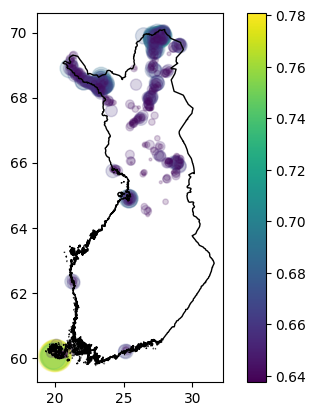

In [128]:
bound = gpd.read_file('data/wind/finland.geojson')
map_ = bound.plot(color='none', edgecolor='black', zorder=2)
_sel = gdf.sort_values(by="score", ascending=False).head(500)
_sizes = (_sel['score'] - _sel['score'].min()) / (_sel['score'].max() - _sel['score'].min()) * 500
_sel.plot(
    ax=map_, column="score", legend=True, figsize=(20, 20), alpha=0.2, markersize=_sizes, zorder=1
)

<Axes: >

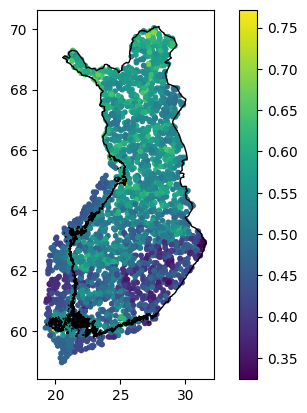

In [129]:
# Very jank, need to directly show rastered image
# Also need to limit to on-land locations
gdf.sample(5000).plot(
    ax=bound.plot(color='none', edgecolor='black', zorder=2),
    column="score", legend=True, figsize=(10, 10), markersize=10,
)

In [164]:
gdf.sort_values(by="score", ascending=False).head(10)

,score,water,powerline,temp,wind,geometry
4299,0.780992,1.000000,1.000000,0.753366,0.516609,POINT (20.04000 60.05000)
3624,0.778388,1.000000,0.925340,0.753366,0.557701,POINT (19.89000 60.05000)
4075,0.775177,1.000000,1.000000,0.753366,0.497224,POINT (19.99000 60.10000)
4300,0.771747,1.000000,1.000000,0.753366,0.485790,POINT (20.04000 60.10000)
4525,0.768683,1.000000,1.000000,0.753366,0.475577,POINT (20.09000 60.10000)
3849,0.766222,1.000000,0.885865,0.753366,0.543463,POINT (19.94000 60.05000)
4524,0.765814,1.000000,1.000000,0.753366,0.466014,POINT (20.09000 60.05000)
4074,0.750387,1.000000,0.825339,0.753366,0.531033,POINT (19.99000 60.05000)
3399,0.736097,1.000000,0.704667,0.753366,0.563846,POINT (19.84000 60.05000)
38245,0.711659,0.390925,1.000000,0.969089,0.475825,POINT (27.54000 69.85000)


# Visualization: Final Scores

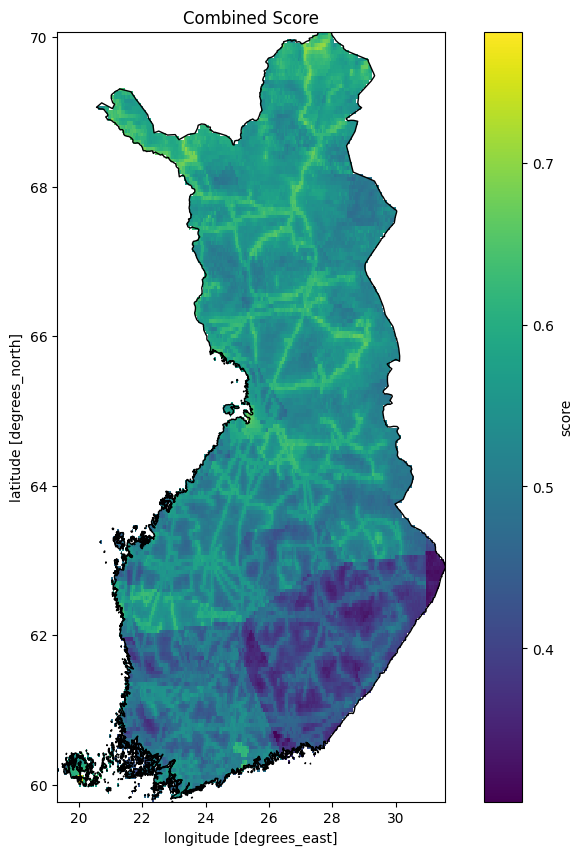

In [148]:
original = da.rio.write_crs("EPSG:4326")
clipped = original.rio.clip(bound.geometry.apply(lambda x: x.buffer(0.01)), bound.crs)
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['score'].plot(ax=map_, cmap='viridis', zorder=1)
map_.set_title("Combined Score")
plt.savefig('imgs/score.png', transparent=True)

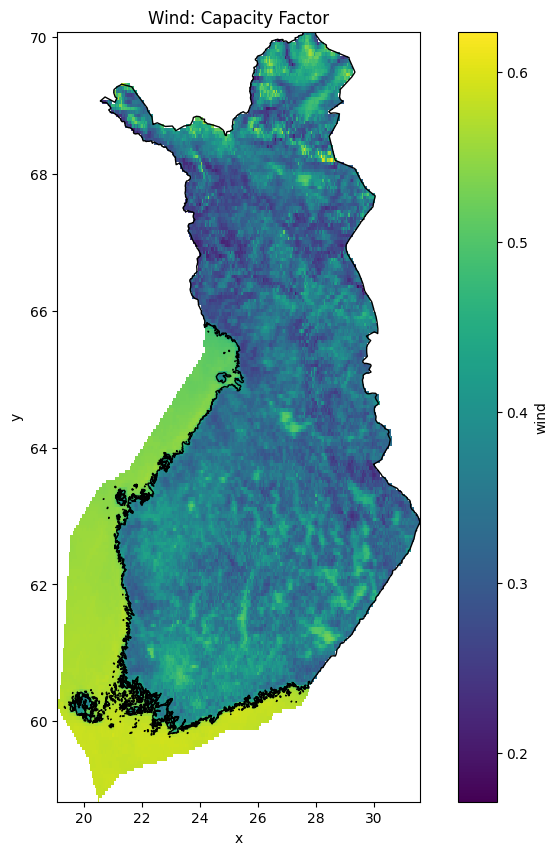

In [149]:
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
original['wind'].plot(ax=map_, cmap='viridis', zorder=1)
map_.set_title("Wind: Capacity Factor")
plt.savefig('imgs/wind.png', transparent=True)

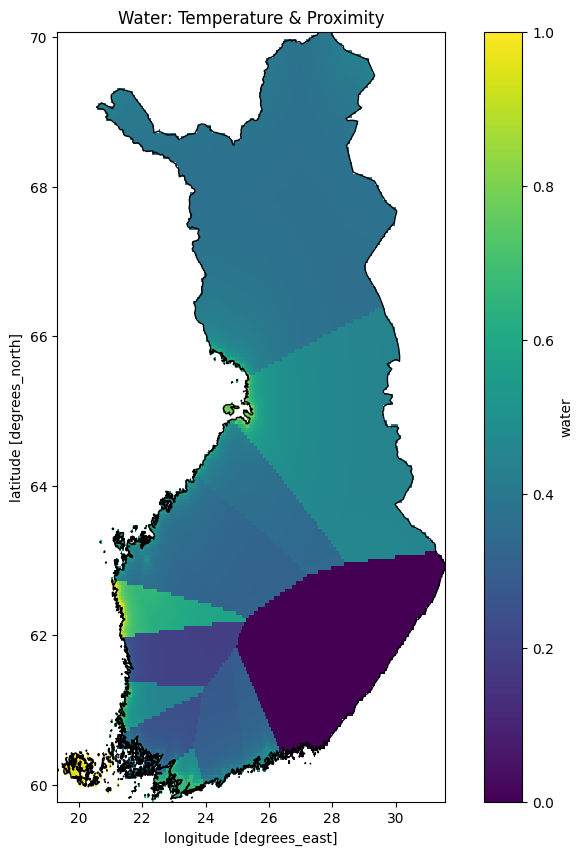

In [150]:
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['water'].plot(ax=map_, cmap='viridis', zorder=1)
map_.set_title("Water: Temperature & Proximity")
plt.savefig('imgs/water.png', transparent=True)

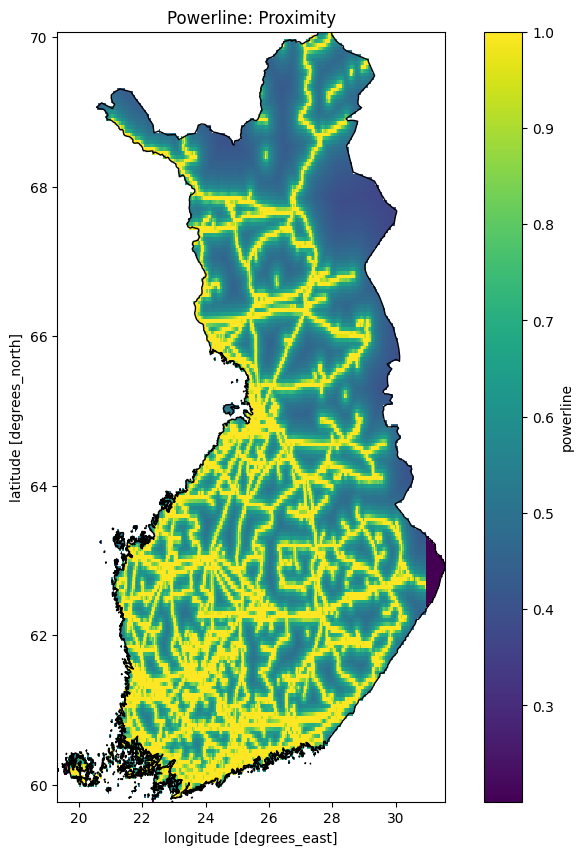

In [161]:
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['powerline'].plot(ax=map_, cmap='viridis', zorder=1)
map_.set_title("Powerline: Proximity")
plt.savefig('imgs/powerline.png', transparent=True)

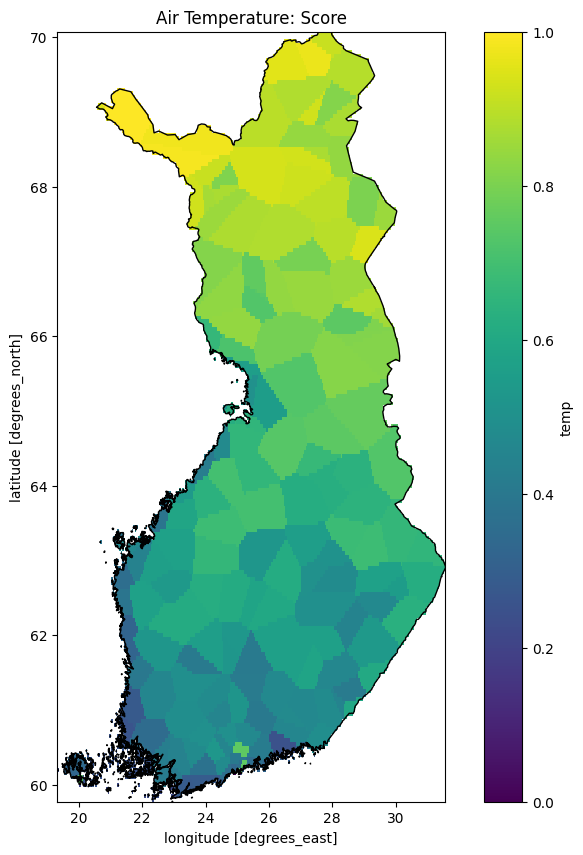

In [154]:
map_ = bound.plot(figsize=(10, 10), color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['temp'].plot(ax=map_, cmap='viridis', zorder=1)
map_.set_title("Air Temperature: Score")
plt.savefig('imgs/temp.png', transparent=True)

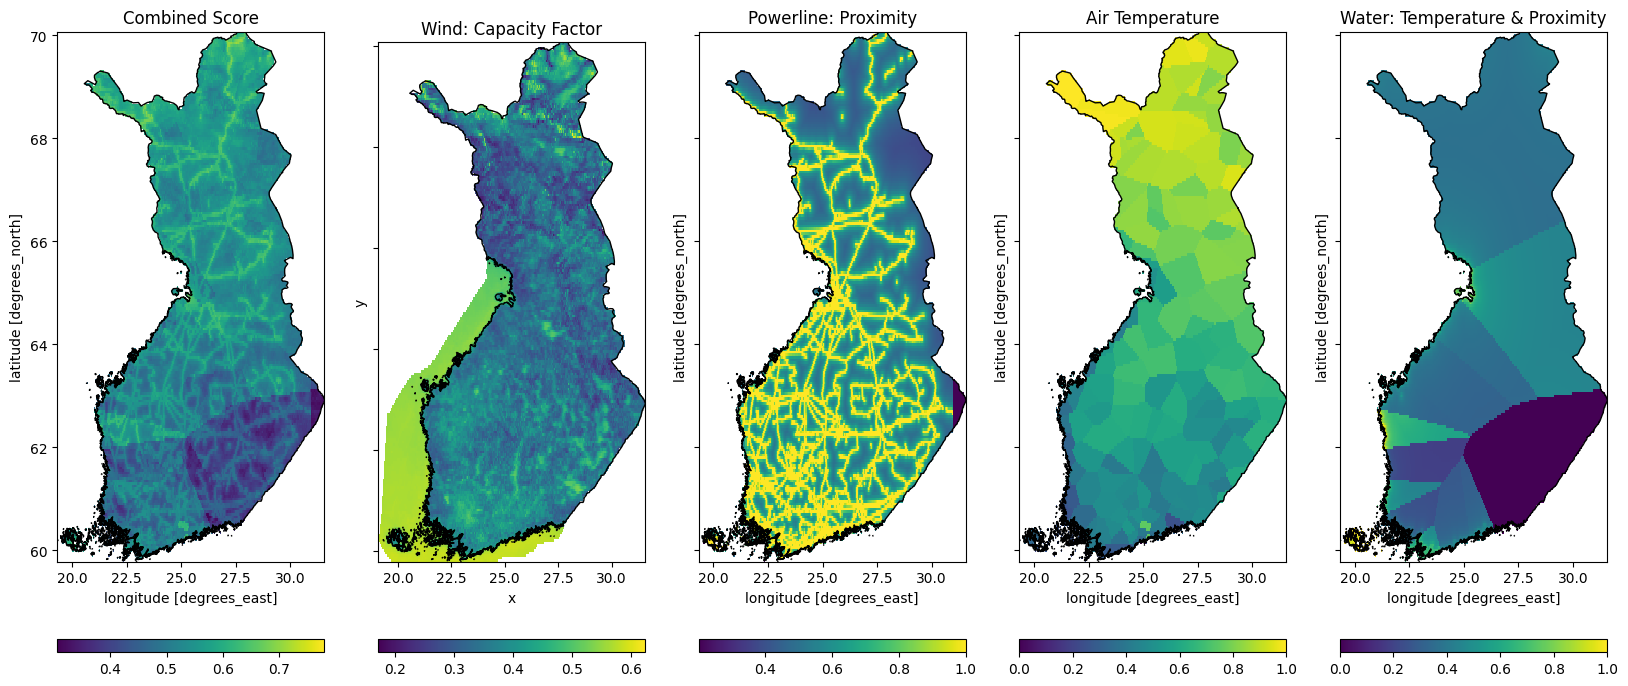

In [160]:
fig, ax = plt.subplots(1, 5, figsize=(20, 20), sharey=True)

cbar = {"location": "bottom", "label": "", "pad": 0.05}

bound.plot(ax=ax[0], color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['score'].plot(ax=ax[0], cmap='viridis', zorder=1, cbar_kwargs=cbar)
ax[0].set_title("Combined Score")

bound.plot(ax=ax[1], color='none', edgecolor='black', linewidth=1, zorder=2)
original['wind'].plot(ax=ax[1], cmap='viridis', zorder=1, cbar_kwargs=cbar)
ax[1].set_title("Wind: Capacity Factor")

bound.plot(ax=ax[2], color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['powerline'].plot(ax=ax[2], cmap='viridis', zorder=1, cbar_kwargs=cbar)
ax[2].set_title("Powerline: Proximity")

bound.plot(ax=ax[3], color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['temp'].plot(ax=ax[3], cmap='viridis', zorder=1, cbar_kwargs=cbar)
ax[3].set_title("Air Temperature")

bound.plot(ax=ax[4], color='none', edgecolor='black', linewidth=1, zorder=2)
clipped['water'].plot(ax=ax[4], cmap='viridis', zorder=1, cbar_kwargs=cbar)
ax[4].set_title("Water: Temperature & Proximity")

plt.savefig('imgs/combined.png', transparent=True)

In [153]:
da.rio.to_raster("data/scores.tif")

CPLE_AppDefinedError: Deleting data/scores.tif failed: Permission denied

TypeError: set_aspect() missing 1 required positional argument: 'aspect'

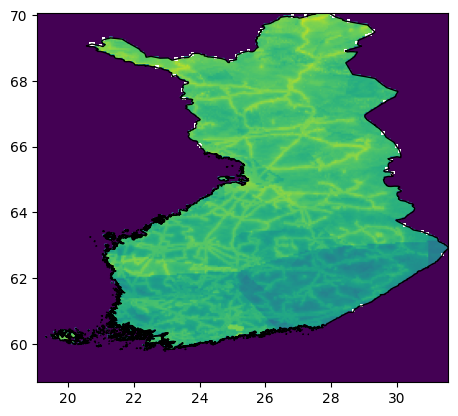

In [ ]:
scores_raster = rasterio.open("data/scores.tif")
masked, _ = rasterio.mask.mask(scores_raster, bound.geometry)
map_ = bound.plot(color='none', edgecolor='black', zorder=2)
img = show(masked[0], ax=map_, cmap='viridis', transform=scores_raster.transform, zorder=1)
img.invert_yaxis()
img.set_aspect()
scores_raster.close()